In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2

依次输出六个图，从左往右，从上往下依次是原图，运动模糊图片，运动模糊且添加噪声图片，信噪比未知维纳滤波结果，信噪比已知维纳滤波结果，图像和噪声自相关函数已知维纳滤波结果。

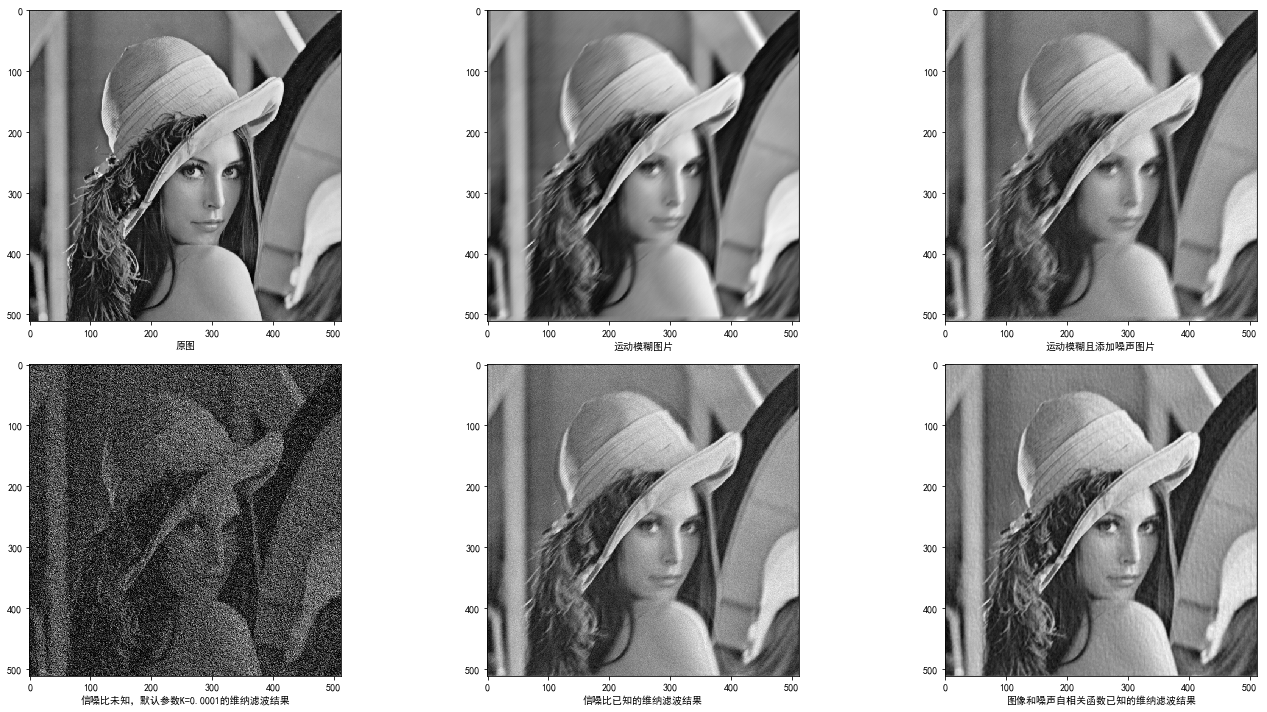

In [2]:
# 仿真运动模糊
def motion_process(image_size,motion_angle):
 PSF = np.zeros(image_size)
 center_position=(image_size[0]-1)/2
 
 slope_tan=math.tan(motion_angle*math.pi/180)
 slope_cot=1/slope_tan
 if slope_tan<=1:
  for i in range(15):
   offset=round(i*slope_tan) 
   PSF[int(center_position+offset),int(center_position-offset)]=1
  return PSF / PSF.sum() #对点扩散函数进行归一化亮度
 else:
  for i in range(15):
   offset=round(i*slope_cot)
   PSF[int(center_position-offset),int(center_position+offset)]=1
  return PSF / PSF.sum()
 
#对图片进行运动模糊
def make_blurred(input, PSF,):
 input_fft = fft.fft2(input)# 进行二维数组的傅里叶变换
 PSF_fft = fft.fft2(PSF)
 blurred = fft.ifft2(input_fft * PSF_fft)
 blurred = np.abs(fft.fftshift(blurred))
 return blurred

#计算信噪比
def SNF_calcu(img, noisy):#img:原图 noisy：有噪声的图片
    img = np.array(img, dtype = float)
    noisy = np.array(noisy, dtype=float)
    noise = img - noisy
    return 10 * np.log10(np.sum(img * img) / np.sum(noise * noise))

 
def wiener(input,PSF,K=0.0001):  #维纳滤波
 input_fft=fft.fft2(input)
 PSF_fft=fft.fft2(PSF)
 PSF_fft_1=np.conj(PSF_fft) /(np.abs(PSF_fft)**2 + K)
 result=fft.ifft2(input_fft * PSF_fft_1)
 result=np.abs(fft.fftshift(result))
 return result
 
image = cv2.imread('lena.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_h=image.shape[0]
img_w=image.shape[1]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(20, 10))
plt.gray()
plt.subplot(231)
plt.xlabel("原图")
plt.imshow(image)


#进行运动模糊处理
PSF = motion_process((img_h,img_w), 60)
blurred = np.abs(make_blurred(image, PSF))
 
plt.subplot(232)
plt.xlabel("运动模糊图片")
plt.imshow(blurred)
 

noise = 0.1 * blurred.std() * np.random.standard_normal(blurred.shape)
blurred_noisy=blurred + noise #添加噪声,standard_normal产生随机的函数

 
plt.subplot(233)
plt.xlabel("运动模糊且添加噪声图片")
plt.imshow(blurred_noisy)  #显示添加噪声且运动模糊的图像
 
 
result=wiener(blurred_noisy,PSF)   #信噪比未知进行维纳滤波
plt.subplot(234)
plt.xlabel("信噪比未知，默认参数K=0.0001的维纳滤波结果")
plt.imshow(result)



k1 = SNF_calcu(image,blurred_noisy)#计算信噪比
k1 = 1/k1#计算噪信比
result=wiener(blurred_noisy,PSF,K=k1)   #信噪比已知进行维纳滤波
plt.subplot(235)
plt.xlabel("信噪比已知的维纳滤波结果")
plt.imshow(result)


NCORR = np.abs(fft.fft2(noise)) * np.abs(fft.fft2(noise))#噪声自相关函数
ICORR = np.abs(fft.fft2(image)) * np.abs(fft.fft2(image))#图像自相关函数

k = NCORR / ICORR
result=wiener(blurred_noisy,PSF,K=k)
plt.subplot(236)
plt.xlabel("图像和噪声自相关函数已知的维纳滤波结果")
plt.imshow(result)

plt.tight_layout()
 
plt.show()